# **Solar Radiation Forecasting MIAR**
###Dans le cadre du Master en IA et Robotique de l'Université des Mascareignes, cette partie du projet consiste à effectuer la prévision de la radiation solaire par l'IA en utilisant des données en temps réel du station météorologique du projet ***IOS-net*** *(**I**ndian **O**cean **S**olar **net**work)* de l'ENERGY-Lab de l'Université de La Réunion installé à ***Vacoas Mauritius***. 
###Les données seront collecté en format netCDF(**net**work **C**ommon **D**ata **F**orm) à travers le serveur TDS, outil de big data supportant ce format particulier dont l'avanage est de permettre de contenir les metadata.

###**NB :** Les données du station météorologique de Vacoas sont logged journalièrement au seveur TDS à compté du *19-10-2019 jusqu'à actuelle.*

# **I- Data Collection** (Accès aux fichier netCDF sur le serveur TDS du IOS-net)


##1- Installation des packages 

In [1]:
! pip install siphon
! pip install seaborn
! pip install numpy
! pip install matplotlib
! pip install urllib3
! pip install netCDF4

     |████████████████████████████████| 69 kB 3.2 MB/s 


##2- Importation des modules

In [2]:
from datetime import datetime, timedelta
import os.path, os
from siphon.catalog import TDSCatalog
from urllib.error import HTTPError
import pandas as pd
# Import some visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
tds_url = 'https://galilee.univ-reunion.fr/thredds/catalog/dataStations/'

##3- Accéder au metadata
Le code ci dessous nous permet de visualiser les metada et ainsi les variables contenu dans chacun de nos fichier netCDF.

In [3]:
tds_base_url = f'{tds_url}/catalog.xml'

# Access the TDS catalogue 
print(f'Requesting {tds_base_url} ...')
cat_base = TDSCatalog(tds_base_url)

# Get catalogue metadata
metadata = cat_base.metadata

# List the variables and their units
variables = metadata['variables']

print('Liste des variables :')

for k,v in variables.items():
    unit = v['units']
    print(f' # {k} ({unit}) ')

Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations//catalog.xml ...
Liste des variables :
 # global_horizontal_irradiance (W m-2) 
 # diffuse_horizontal_irradiance (W m-2) 
 # UV_irradiance_on_A_and_B_band (W m-2) 
 # relative_humidity (%RH) 
 # air_pressure (hPA) 
 # rainfall (mm) 
 # air_temperature (degree Celsius) 
 # dew_point_temperature (degree Celsius) 
 # wind_direction  (degree) 
 # standard_deviation_of_wind_direction (degree) 
 # wind_speed (m s-1) 
 # wind_speed_max_of_gust (m s-1) 
 # minimum_datalogger_voltage (degree Celsius) 
 # thermocouple_box_temperature (degree Celsius) 
 # datalogger_intern_temperature (degree Celsius) 
 # solar_panel_back_surface_temperature (degree Celsius) 


## 3) Accéder à distance au fichier

Les données netCDF disponible sur le serveur TDS sont générer de facon à contenir chancun des fichiers journlière.

Accessible via le lien : 
https://galilee.univ-reunion.fr/thredds/catalog/dataStations/catalog.html

###a- Analyse des données premièrement disponible sur le serveur TDS

Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2019/catalog.xml ...
Found 1 file(s) : [1572415339_2019-10-29.nc]
 1440 values found for variable "time" ,correspondant au données par minutes journalière 


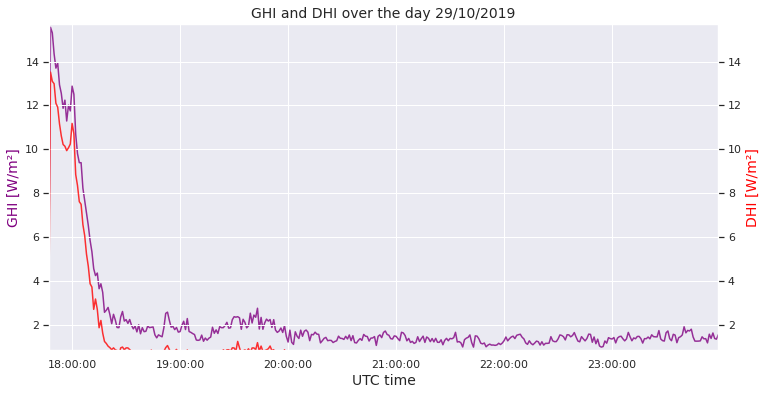

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'    
YEAR = 2019
MONTH = '10' # MONTH format must be a two character string : 'xx'
DAY = '29'  # DAY format must be a two character string : 'xx'

# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]   
GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]

# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)

ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')


# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

**Commentaire du graphe : **

Comme on voit sur le graph ci dessus, les données récoltés lors debut du lancement de la station, c-à-dire du *19-10-2019*, n'est pas complète mais commence vers *18h*, donc ne nous est pas utile pour notre projet de prévision. La raison principale c'est que les données mis à part des horraires présenté sur la courbe ci dessus, de la date 19-10-2019, sont toutes **NA**.

###b- Analyse des données dernièrement disponible sur le serveur TDS

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'   
date = datetime.utcnow() 
YEAR = date.year
YEAR=2022
MONTH = date.month # MONTH format must be a two character string : 'xx'
#Get last date logged(yesterday)
lastdate = datetime.now() + timedelta(days=-2)  
DAY='0'+str(lastdate.day)  # DAY format must be a two character string : 'xx'
print(f'DAY : {DAY}')
print(f'MONTH : {MONTH}')
#datetime.timedelta(days=1)
# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]  

GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]

# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)

ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')


# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

DAY : 017
MONTH : 5
Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2022/catalog.xml ...
Found 0 file(s) : []


IndexError: ignored

Voici à la courbe ci dessus, un exemple d'illustration de donnée journalière complète receillit chaque minute de la journée de hier.

Ici notre variable de sortie est le GHI (global_horizontal_irradiance) en (W/m^2)
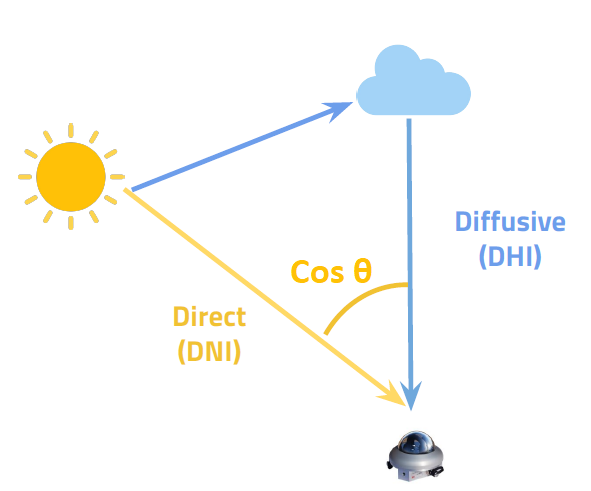


GHI = DHI + cos(𝞡) *DNI

###c- Filtrage des variables  
Ici on va choisir les variables qui peuvent avoir des reletions direct pour la prévision de l'ensoillement. C'est à dire les variables d'entrer et variable de sortie de notre LSTM.

Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2022/catalog.xml ...
Found 1 file(s) : [1572415339_2022-01-12.nc]
 1440 values found for variable "time" ,correspondant au données par minutes journalière 


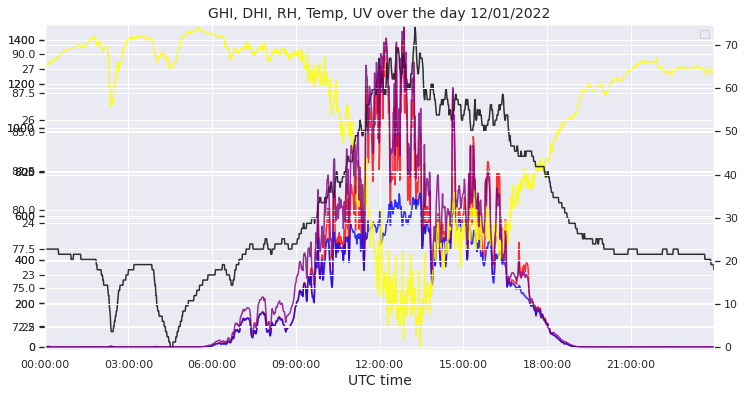

In [15]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'    
YEAR = 2022
MONTH = '01' # MONTH format must be a two character string : 'xx'
DAY = '12'  # DAY format must be a two character string : 'xx'

# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]   
GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]
RH = data['relative_humidity'][:]
Temp = data['air_temperature'][:]
UV = data['UV_irradiance_on_A_and_B_band'][:]
P = data['air_pressure'][:]
Wind = data['wind_speed'][:]
dT = data['dew_point_temperature'][:]
# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax2.twinx()
ax4 = ax3.twinx()
ax5 = ax4.twinx()



ax1.plot(T_dt, GHI, c = 'red', alpha = 0.8)
ax2.plot(T_dt, DHI, c='blue', alpha = 0.8)
ax3.plot(T_dt, RH, c='yellow', alpha = 0.8)
ax4.plot(T_dt, Temp, c='black', alpha = 0.8)
ax5.plot(T_dt, UV, c='purple', alpha = 0.8)



ax1.set_xlabel("UTC time")

ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI, DHI, RH, Temp, UV over the day {DAY}/{MONTH}/{YEAR}')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

**Avec :**
> - global_horizontal_irradiance (GHI) : purple
> - diffuse_horizontal_irradiance (DHI) : red
> - relative_humidity (RH) : blue
> - air_temperature (Temp) : black
> - air_pressure (P) : yellow
> - UV_irradiance_on_A_and_B_band (UV) : red
> - dew_point_temperature (dT) : orange

Le graphe des variable ci dessus nous permet de filtrer les variables qui n'ont pas de relation claire avec notre variable de sortie.

A partir de ce graphe on peut donc déduire que les variables en correlation avec notre variable de sortie GHI sont :
> - GHI (global_horizontal_irradiance (W m-2))
> - DHI (diffuse_horizontal_irradiance (W m-2))
> - RH (relative_humidity (%RH))
> - Temp (air_temperature (degree Celsius))
> - UV (UV_irradiance_on_A_and_B_band (W m-2))

Voici la courbe ci dessus, un exemple d'illustration des variables du metadata journalière receillit chaque minute par le station météorologique de vacoas.

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'    
date = datetime.utcnow() 
YEAR = date.year
MONTH = date.month # MONTH format must be a two character string : 'xx'
#Now let get last date logged(yesterday date)
lastdate = datetime.now() + timedelta(days=-2)  
DAY=lastdate.day  # DAY format must be a two character string : 'xx'

# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]   
GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]
RH = data['relative_humidity'][:]
Temp = data['air_temperature'][:]
UV = data['UV_irradiance_on_A_and_B_band'][:]

# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax2.twinx()
ax4 = ax3.twinx()
ax5 = ax4.twinx()



ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)
ax3.plot(T_dt, RH, c='blue', alpha = 0.8)
ax4.plot(T_dt, Temp, c='black', alpha = 0.8)
ax5.plot(T_dt, UV, c='green', alpha = 0.8)



ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2022/catalog.xml ...
Found 0 file(s) : []


IndexError: ignored

**Avec :**
> - GHI : purple
> - DHI : red
> - RH : blue
> - Temp : black
> - UV : green

###d- Sauvegarder les variables pour notre LSTM
Ici on va sauvegarder localement en sour forme de dictionnaire en format **.csv** les variables qui peuvent avoir des reletions direct pour la prévision de l'ensoillement, à savoir : 

> - GHI (global_horizontal_irradiance (W m-2))
> - DHI (diffuse_horizontal_irradiance (W m-2))
> - RH (relative_humidity (%RH))
> - Temp (air_temperature (degree Celsius))
> - UV (UV_irradiance_on_A_and_B_band (W m-2))

In [ ]:
import numpy as np
import pandas as pd

dic={'time':[],'GHI':[],'DHI':[],'RH':[],'Temp':[],'UV':[]}
years=[]
files=[]
dude='1572415339_2019-10-29.nc'
for i in range(2019,date.year+1):
  
  url=f'{tds_url}{COUNTRY}/{STATION}/{i}/catalog.xml'
  print("")
  print(f'> - Year {i}')

  print(f'Requesting {url} ...')

  cat = TDSCatalog(url)
  print(f'    -> Success')

  # Select the right file
  #Skipping the first file named "1572415339_2019-10-29.nc" as we have explained earler (contain to much NA values)
  selection = [d for d in cat.datasets[:] if '1572415339_2019-10-29' not in d.name]
  selection.reverse()
  print(f'Found {len(selection)} file(s) : {selection}')

  
  

  # Access the data
  print('Accessing file on server...')



> - Year 2019
Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2019/catalog.xml ...
    -> Success
Found 63 file(s) : [1572415339_2019-10-30.nc, 1572415339_2019-10-31.nc, 1572415339_2019-11-01.nc, 1572415339_2019-11-02.nc, 1572415339_2019-11-03.nc, 1572415339_2019-11-04.nc, 1572415339_2019-11-05.nc, 1572415339_2019-11-06.nc, 1572415339_2019-11-07.nc, 1572415339_2019-11-08.nc, 1572415339_2019-11-09.nc, 1572415339_2019-11-10.nc, 1572415339_2019-11-11.nc, 1572415339_2019-11-12.nc, 1572415339_2019-11-13.nc, 1572415339_2019-11-14.nc, 1572415339_2019-11-15.nc, 1572415339_2019-11-16.nc, 1572415339_2019-11-17.nc, 1572415339_2019-11-18.nc, 1572415339_2019-11-19.nc, 1572415339_2019-11-20.nc, 1572415339_2019-11-21.nc, 1572415339_2019-11-22.nc, 1572415339_2019-11-23.nc, 1572415339_2019-11-24.nc, 1572415339_2019-11-25.nc, 1572415339_2019-11-26.nc, 1572415339_2019-11-27.nc, 1572415339_2019-11-28.nc, 1572415339_2019-11-29.nc, 1572415339_2019-11-30.nc, 15724153

In [ ]:
import numpy as np
import pandas as pd

dic={'time':[],'GHI':[],'DHI':[],'RH':[],'Temp':[],'UV':[]}
years=[]
files=[]

for i in range(2019,date.year+1):
    
  url=f'{tds_url}{COUNTRY}/{STATION}/{i}/catalog.xml'
  print("-----------------------------------------------------------")
  print(f'> - Year {i}')

  print(f'Requesting {url} ...')

  cat = TDSCatalog(url)
  print(f'    -> Success')

  # Select the right file
  #Skipping the first file named "1572415339_2019-10-29.nc" as we have explained earler (contain to much NA values)
  selection = [d for d in cat.datasets[:] if '1572415339_2019-10-29' not in d.name]
  selection.reverse()
  print(f'Found {len(selection)} file(s) : {selection}')

  
  
  # Access the data
  print('Accessing file on server...')


  for files in selection:
  
    data = files.remote_access()
    print(f'   -> 1 Day file "{files}" Done')

    # save each netCDF files values inside 'dic' dictionnary for each .nc files(1440 values) and each year(2019-2022), and Convert unix time in a datetime format
    dic['time'].extend([ datetime.fromtimestamp(t) for t in data['time'][:]] )
    dic['GHI'].extend(data['total_horizontal_irradiance'][:])
    dic['DHI'].extend(data['diffuse_horizontal_irradiance'][:])
    dic['RH'].extend(data['relative_humidity'][:])
    dic['Temp'].extend(data['air_temperature'][:])
    dic['UV'].extend(data['UV_irradiance_on_A_and_B_band'][:])


    arr=data['total_horizontal_irradiance'][:]
    print(f'{len(arr)} values for variable "GDI" ')

    

  print(f'my_dict : {len(dic)}') 
  
 
  #convert dictionnary to dataframe
  df = pd.DataFrame(dic)
  
  #show dataframe for each files passed
  print(df)

#save dataframe to csv format
df.to_csv('iosnet_df.csv',index=False)

NameError: ignored

#4) Preparation du dataset

###Importation des variables depuis le dataset csv precedement sauvegarder
"Cancel the upload process if file is already loaded"

In [ ]:
from google.colab import files

#Upload the csv file from pc(Juste cancel si on va pas improter depuis PC)
files.upload()

#Read the csv file
df = pd.read_csv('iosnet_df.csv')
df.head()

,time,GHI,DHI,RH,Temp,UV
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001


Creation des nouveaux variables :
> - date
> - year
> - day
> - jday (julian day 1 à 365/366 jours)
> - hour
> - minute

In [ ]:
df.head()

,time,GHI,DHI,RH,Temp,UV
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001


###Répartitionner la Date en year, month, day, minute

In [ ]:
df['time']=pd.to_datetime(df['time'])
df['date']=pd.to_datetime(df['time']).dt.date

df['year']=df['time'].apply(lambda x: x.year)
df['month']=df['time'].apply(lambda x: x.month)
df['day']=df['time'].apply(lambda x: x.day)
df['jday'] = df['time'].apply(lambda x: x.timetuple().tm_yday )
df['hour']=df['time'].apply(lambda x: x.hour)
df['minute']=df['time'].apply(lambda x: x.minute)

df.head()


,time,GHI,DHI,RH,Temp,UV,date,year,month,day,jday,hour,minute
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001,2019-10-30,2019,10,30,303,0,0
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001,2019-10-30,2019,10,30,303,0,1
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001,2019-10-30,2019,10,30,303,0,2
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001,2019-10-30,2019,10,30,303,0,3
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001,2019-10-30,2019,10,30,303,0,4


Verification **NA** value

In [ ]:
train_features0 = df.drop(columns=['date','year','month','hour','minute','time','UV'])
train_features0.head()

,GHI,DHI,RH,Temp,day,jday
0,1.584,0.616,84.3,18.30,30,303
1,1.714,0.621,84.6,18.30,30,303
2,1.357,0.603,84.7,18.28,30,303
3,1.436,0.521,84.7,18.20,30,303
4,1.658,0.646,84.6,18.20,30,303


In [ ]:
#find if there are some NA value in dataset
df['GHI'].isnull().sum()

3208

###Remplacer NAN value by 0

In [ ]:
df['GHI'] = df['GHI'].fillna(int(0)) 
df['DHI'] = df['DHI'].fillna(int(0)) 
df['RH'] = df['RH'].fillna(int(0)) 
df['Temp'] = df['Temp'].fillna(int(0)) 
df['UV'] = df['UV'].fillna(0) 

In [ ]:
df.head()

,time,GHI,DHI,RH,Temp,UV,date,year,month,day,jday,hour,minute
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001,2019-10-30,2019,10,30,303,0,0
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001,2019-10-30,2019,10,30,303,0,1
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001,2019-10-30,2019,10,30,303,0,2
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001,2019-10-30,2019,10,30,303,0,3
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001,2019-10-30,2019,10,30,303,0,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231200 entries, 0 to 1231199
Data columns (total 13 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   time    1231200 non-null  datetime64[ns]
 1   GHI     1231200 non-null  float64       
 2   DHI     1231200 non-null  float64       
 3   RH      1231200 non-null  float64       
 4   Temp    1231200 non-null  float64       
 5   UV      1231200 non-null  object        
 6   date    1231200 non-null  object        
 7   year    1231200 non-null  int64         
 8   month   1231200 non-null  int64         
 9   day     1231200 non-null  int64         
 10  jday    1231200 non-null  int64         
 11  hour    1231200 non-null  int64         
 12  minute  1231200 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(6), object(2)
memory usage: 122.1+ MB


#Here we go ----------------------------------

### F-score

One of the simplest ways to select relevant features is to calculate the F-Score for each feature. The F-Score is calculated using the variance between the features and the variance within each feature. A high F-score usually means that the feature is more important than a feature with a low F-score. 

In [ ]:
train_labels = df['GHI'].to_numpy()
train_features = df.drop(columns=['GHI','date','year','month','day','jday','hour','minute','time','UV']).to_numpy()

In [ ]:
train_features

array([[ 0.616, 84.3  , 18.3  ],
       [ 0.621, 84.6  , 18.3  ],
       [ 0.603, 84.7  , 18.28 ],
       ...,
       [ 0.538, 80.9  , 22.4  ],
       [ 0.546, 80.9  , 22.33 ],
       [ 0.547, 80.8  , 22.3  ]])

In [ ]:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=3)
selected_features = selector.fit_transform(train_features, train_labels)

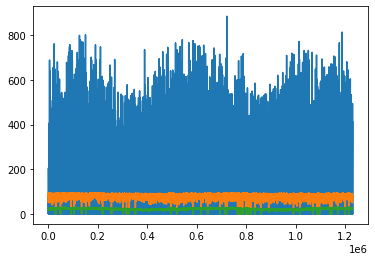

In [ ]:
# Plot the data
plt.plot(selected_features)

###Agreggation par jour avec un seul feature à l'entré
Comme on a des données séquentielles de chaque minutes depuis le serveur TDS de IOS-net, on va faire la moyenne pour obtenir des données plutot journalière.

Ici, on vas utilisé comme feature, le GHI à l'entré pour prédire une label GHI suivante à la sortie (une label GHI correspond à une prédiction d'une journé suivante)

In [ ]:
#Aggregation par date avec une seul feature à l'entré et une label à la sortie
#df2 = df.groupby('date')['GHI','DHI','RH','Temp','UV','day','jday',].mean()
df2 = df.groupby('year')['GHI','DHI','RH','Temp','UV','day','jday',].mean()
print(df2)

             GHI         DHI         RH       Temp        day        jday
year                                                                     
2019  236.700290  104.024310  80.951835  22.810480  16.222222  334.000000
2020  213.674130   91.814043  81.044024  20.938219  15.756831  183.500000
2021  213.685094   88.906367  80.876795  21.255556  15.720548  183.000000
2022  225.087296  100.671663  79.967310  23.574646  15.409836   40.295082


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df2.to_csv('df2.csv')

In [ ]:
df0 = pd.read_csv("df2.csv")
df0.head()

,hour,GHI,DHI,RH,Temp,day,jday
0,0,1.294549,0.569645,87.052843,20.011997,15.750877,184.159064
1,1,1.294938,0.568346,87.384139,19.884727,15.750877,184.159064
2,2,1.285093,0.564139,87.627245,19.782823,15.750877,184.159064
3,3,1.280449,0.563153,87.816206,19.695465,15.750877,184.159064
4,4,1.277308,0.563363,87.949209,19.625544,15.750877,184.159064


### Import library and modules

In [ ]:
from math import sqrt
from numpy import concatenate
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from matplotlib import pyplot

###  Convert series to supervised learning

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Dataset preparation

In [ ]:
# load dataset
#dataset = read_csv('df2.csv', header = 0, index_col=0)
dataset = read_csv('df2.csv')
dataset.head()


,hour,GHI,DHI,RH,Temp,day,jday
0,0,1.294549,0.569645,87.052843,20.011997,15.750877,184.159064
1,1,1.294938,0.568346,87.384139,19.884727,15.750877,184.159064
2,2,1.285093,0.564139,87.627245,19.782823,15.750877,184.159064
3,3,1.280449,0.563153,87.816206,19.695465,15.750877,184.159064
4,4,1.277308,0.563363,87.949209,19.625544,15.750877,184.159064


### Convertir notre pandas dataframe vers numpy array

In [ ]:
#np_date = dataset['date'].to_numpy()
np_date = dataset['hour'].to_numpy()
np_date.shape


(24,)

###==========================================================================================

In [ ]:
dataset1 = dataset.drop(columns=['hour'])
dataset1.head()

,GHI,DHI,RH,Temp,day,jday
0,1.294549,0.569645,87.052843,20.011997,15.750877,184.159064
1,1.294938,0.568346,87.384139,19.884727,15.750877,184.159064
2,1.285093,0.564139,87.627245,19.782823,15.750877,184.159064
3,1.280449,0.563153,87.816206,19.695465,15.750877,184.159064
4,1.277308,0.563363,87.949209,19.625544,15.750877,184.159064


####Convert dataframe to array

In [ ]:
values = dataset1.values
values

array([[1.29454869e+00, 5.69645049e-01, 8.70528433e+01, 2.00119969e+01,
        1.57508772e+01, 1.84159064e+02],
       [1.29493817e+00, 5.68345653e-01, 8.73841392e+01, 1.98847265e+01,
        1.57508772e+01, 1.84159064e+02],
       [1.28509312e+00, 5.64139454e-01, 8.76272450e+01, 1.97828231e+01,
        1.57508772e+01, 1.84159064e+02],
       [1.28044871e+00, 5.63152827e-01, 8.78162060e+01, 1.96954645e+01,
        1.57508772e+01, 1.84159064e+02],
       [1.27730836e+00, 5.63363333e-01, 8.79492086e+01, 1.96255441e+01,
        1.57508772e+01, 1.84159064e+02],
       [3.99206524e+00, 2.81381873e+00, 8.81996096e+01, 1.96554653e+01,
        1.57508772e+01, 1.84159064e+02],
       [5.32703686e+01, 2.75380582e+01, 8.75654522e+01, 1.99227236e+01,
        1.57508772e+01, 1.84159064e+02],
       [2.08470240e+02, 8.43830268e+01, 8.42226078e+01, 2.08204218e+01,
        1.57508772e+01, 1.84159064e+02],
       [3.99743210e+02, 1.52954726e+02, 7.91161203e+01, 2.19230821e+01,
        1.57508772e+01, 

#### Ensure all data is float

In [ ]:
values = values.astype('int32')
values

array([[  1,   0,  87,  20,  15, 184],
       [  1,   0,  87,  19,  15, 184],
       [  1,   0,  87,  19,  15, 184],
       [  1,   0,  87,  19,  15, 184],
       [  1,   0,  87,  19,  15, 184],
       [  3,   2,  88,  19,  15, 184],
       [ 53,  27,  87,  19,  15, 184],
       [208,  84,  84,  20,  15, 184],
       [399, 152,  79,  21,  15, 184],
       [556, 218,  74,  22,  15, 184],
       [656, 267,  71,  23,  15, 184],
       [716, 291,  70,  23,  15, 184],
       [700, 292,  69,  23,  15, 184],
       [633, 272,  70,  23,  15, 184],
       [533, 233,  70,  23,  15, 184],
       [391, 181,  72,  23,  15, 184],
       [234, 118,  75,  22,  15, 184],
       [ 76,  53,  78,  21,  15, 184],
       [ 10,   8,  82,  21,  15, 184],
       [  1,   0,  84,  20,  15, 184],
       [  1,   0,  85,  20,  15, 184],
       [  1,   0,  85,  20,  15, 184],
       [  1,   0,  86,  20,  15, 184],
       [  1,   0,  86,  20,  15, 184]], dtype=int32)

In [ ]:
# normalise features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [ ]:
n_mins = 7
n_features = 6
reframed = series_to_supervised(values, n_mins, 2)

In [ ]:
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),...,var3(t),var4(t),var5(t),var6(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var6(t+1)
7,1.0,0.0,87.0,20.0,15.0,184.0,1.0,0.0,87.0,19.0,...,84,20,15,184,399.0,152.0,79.0,21.0,15.0,184.0
8,1.0,0.0,87.0,19.0,15.0,184.0,1.0,0.0,87.0,19.0,...,79,21,15,184,556.0,218.0,74.0,22.0,15.0,184.0
9,1.0,0.0,87.0,19.0,15.0,184.0,1.0,0.0,87.0,19.0,...,74,22,15,184,656.0,267.0,71.0,23.0,15.0,184.0
10,1.0,0.0,87.0,19.0,15.0,184.0,1.0,0.0,87.0,19.0,...,71,23,15,184,716.0,291.0,70.0,23.0,15.0,184.0
11,1.0,0.0,87.0,19.0,15.0,184.0,3.0,2.0,88.0,19.0,...,70,23,15,184,700.0,292.0,69.0,23.0,15.0,184.0


In [ ]:
reframed['var1(t)']

20     185
21     237
22     137
23     236
24     202
      ... 
849    280
850    194
851    155
852    199
853    232
Name: var1(t), Length: 834, dtype: int32

In [ ]:
reframed['var1(t+1)']

20     237.0
21     137.0
22     236.0
23     202.0
24     204.0
       ...  
849    194.0
850    155.0
851    199.0
852    232.0
853    196.0
Name: var1(t+1), Length: 834, dtype: float64

#### Split into train and test sets

In [ ]:
len(values)

0

In [ ]:
values = reframed.values
n_train_mins = int(len(values)*60/100)
train = values[:n_train_mins, :]
test = values[n_train_mins:, :]

#### Split into input and outputs

In [ ]:
n_obs = n_mins * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X,  test_y =test[:, :n_obs], test[:, n_obs:]

In [ ]:
train_y = train_y[:,[0,n_features]]
test_y = test_y[:,[0,n_features]]

In [ ]:
train_X.shape

(0, 144)

###Scaling Train and Test sets

Train scaling

In [ ]:
# normalise features
scaler_train_X = MinMaxScaler(feature_range=(0,1))
scaled_train_X = scaler_train_X.fit_transform(train_X)

# normalise features
scaler_train_y = MinMaxScaler(feature_range=(0,1))
scaled_train_y = scaler_train_y.fit_transform(train_y)

ValueError: ignored

Test scaling

In [ ]:
# normalise features
scaler_test_X = MinMaxScaler(feature_range=(0,1))
scaled_test_X = scaler_test_X.fit_transform(test_X)

# normalise features
scaler_test_y = MinMaxScaler(feature_range=(0,1))
scaled_test_y = scaler_test_y.fit_transform(test_y)

In [ ]:
train_y = scaled_train_y
test_y = scaled_test_y

As we may already know, we have : 
* input variable = 6 (GHI, GDI, RH, Temp, day, jday)
* sequence = 7 (last 7 days)

Now we need to predict only GHI on our OUTPUT, because by default our series_to_supervised(caled, n_mins, 2) function return 12 value on OUTPUT (2 sequences * 6 variables), thus we need to update the OUTPUT variable :

In [ ]:
test_X.shape

(334, 120)

In [ ]:
n_features

6

In [ ]:
test_y.shape

(334, 2)

#### Reshape input to be 3D [samples, timesteps(sequences), nb features]

Original shape

In [ ]:
train_X.shape, train_y.shape

((500, 120), (500, 2))

In [ ]:
test_X

array([[[0.77993528, 0.39735099, 0.67647059, 0.77777778, 0.4       ,
         0.19505495],
        [0.42071197, 0.75496689, 0.93478261, 0.83333333, 0.43333333,
         0.1978022 ],
        [0.40776699, 0.74834437, 0.89130435, 0.75      , 0.46666667,
         0.20054945],
        ...,
        [0.23624595, 0.20529801, 0.91304348, 0.75      , 0.96666667,
         0.24175824],
        [0.4368932 , 0.21192053, 0.84782609, 0.83333333, 1.        ,
         0.24450549],
        [0.64401294, 0.45033113, 0.82608696, 0.91666667, 0.        ,
         0.24725275]],

       [[0.42071197, 0.75496689, 0.91176471, 0.77777778, 0.43333333,
         0.1978022 ],
        [0.40776699, 0.74834437, 0.89130435, 0.75      , 0.46666667,
         0.20054945],
        [0.73139159, 0.42384106, 0.73913043, 0.83333333, 0.5       ,
         0.2032967 ],
        ...,
        [0.4368932 , 0.21192053, 0.84782609, 0.83333333, 1.        ,
         0.24450549],
        [0.64401294, 0.45033113, 0.82608696, 0.91666667, 0.   

Reshape input to 3D [samples, timesteps(sequences), nb features]

In [ ]:
train_X = scaled_train_X.reshape((scaled_train_X.shape[0], n_mins, n_features))
test_X = scaled_test_X.reshape((scaled_test_X.shape[0], n_mins, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(491, 14, 6) (491, 2) (328, 14, 6) (328, 2)


In [ ]:
test_y.shape

(339, 2)

In [ ]:
train_y.shape, test_y.shape

((423, 2), (424, 2))

#### Design network

In [ ]:
import keras
# design network
#layers = [0,128,256,64,2]
layers = [0,64,128,64,2]

model = Sequential()

model.add(LSTM(
	layers[1],
	input_shape=(train_X.shape[1], train_X.shape[2]),
	return_sequences=True))

model.add(Dropout(0.4))  #drop some connection to prevent overfiting

model.add(LSTM(
        layers[2],
        return_sequences=True))

model.add(Dropout(0.4))

model.add(LSTM(
        layers[3],
        return_sequences=False))

model.add(Dropout(0.4))

#model.add(Dense(layers[4]*3))
#model.add(Dense(layers[4]*2))
model.add(Dense(layers[4]))

model.add(Activation("sigmoid"))

model.compile(loss='mae', optimizer='adam')


#Early stopping the training process(prevent overfiting)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#model.fit(train_X, train_y, callbacks=[es_callback])


# fit network
history = model.fit(train_X, train_y, epochs = 100, batch_size=5, validation_data = (test_X, test_y), verbose=2, shuffle=False, callbacks=[es_callback])


Epoch 1/100
99/99 - 24s - loss: 0.1463 - val_loss: 0.2029 - 24s/epoch - 243ms/step
Epoch 2/100
99/99 - 3s - loss: 0.1521 - val_loss: 0.1831 - 3s/epoch - 26ms/step
Epoch 3/100
99/99 - 3s - loss: 0.1583 - val_loss: 0.2136 - 3s/epoch - 26ms/step
Epoch 4/100
99/99 - 3s - loss: 0.1563 - val_loss: 0.2396 - 3s/epoch - 26ms/step
Epoch 5/100
99/99 - 3s - loss: 0.1595 - val_loss: 0.2160 - 3s/epoch - 26ms/step
Epoch 6/100
99/99 - 3s - loss: 0.1695 - val_loss: 0.1634 - 3s/epoch - 25ms/step
Epoch 7/100
99/99 - 3s - loss: 0.1627 - val_loss: 0.1641 - 3s/epoch - 26ms/step
Epoch 8/100
99/99 - 3s - loss: 0.1618 - val_loss: 0.1651 - 3s/epoch - 25ms/step
Epoch 9/100
99/99 - 3s - loss: 0.1606 - val_loss: 0.1659 - 3s/epoch - 26ms/step
Epoch 10/100
99/99 - 3s - loss: 0.1601 - val_loss: 0.1661 - 3s/epoch - 26ms/step
Epoch 11/100
99/99 - 3s - loss: 0.1605 - val_loss: 0.1663 - 3s/epoch - 26ms/step
Epoch 12/100
99/99 - 3s - loss: 0.1591 - val_loss: 0.1664 - 3s/epoch - 26ms/step
Epoch 13/100
99/99 - 3s - loss: 0.

#### plot history

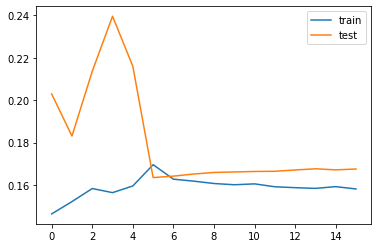

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

###=============================================================================

####Test set date

In [ ]:
np_date.shape, values.shape

((855,), (847, 54))

In [ ]:
test_y.shape

(339, 2)

In [ ]:
date = np_date[-len(test_y):]

In [ ]:
date.shape

(339,)

### Make a prediction

In [ ]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],n_mins * n_features))
print(yhat.shape,test_X.shape)




(424, 2) (424, 42)


In [ ]:
inv_yhat.shape

(339, 4)

In [ ]:
yhat.shape

(339, 2)

### Invert scaling for forecast

In [ ]:
inv_yhat = concatenate((test_X[:, -5:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,[-2,-1]]



ValueError: ignored

In [ ]:
inv_yhat2.shape

(339, 2)

### Invert scaling for actual

In [ ]:
test_X.shape,test_y.shape

((339, 42), (339, 2))

In [ ]:
len(test_X)

339

In [ ]:
inv_y

array([[ 16.04322767, 132.48414986],
       [ 11.80691643, 105.13544669],
       [  9.55907781, 170.35158501],
       [ 14.91930836, 237.67146974],
       [ 20.45244957, 251.34582133],
       [ 21.57636888, 253.44956772],
       [ 21.74927954, 268.17579251],
       [ 22.95965418, 239.77521614],
       [ 20.62536023, 207.16714697],
       [ 17.94524496, 215.58213256],
       [ 18.63688761, 209.27089337],
       [ 18.11815562, 178.76657061],
       [ 15.61095101,  93.5648415 ],
       [  8.60806916, 154.57348703],
       [ 13.62247839, 136.69164265],
       [ 12.15273775, 205.06340058],
       [ 17.77233429, 210.32276657],
       [ 18.20461095, 208.21902017],
       [ 18.03170029,  78.83861671],
       [  7.39769452, 192.44092219],
       [ 16.73487032, 105.13544669],
       [  9.55907781, 225.04899135],
       [ 19.41498559, 145.10662824],
       [ 12.8443804 , 151.41786744],
       [ 13.36311239,  91.4610951 ],
       [  8.4351585 ,  97.77233429],
       [  8.95389049, 128.27665706],
 

In [ ]:
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1])

In [ ]:
inv_y = concatenate((test_X[:, -5:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,[-2,-1]]


In [ ]:
y_pred = inv_yhat[:]
y_true = inv_y[:]

In [ ]:
y_pred.shape, y_true.shape

((340,), (340,))

# V Test performance du model

### Bias
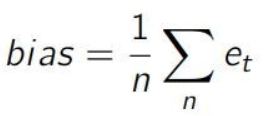

avec:

Forecast error

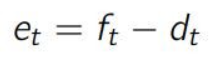

In [ ]:
bias = (y_true - y_pred).mean()
print(f'Bias : {bias :.4f}')

Bias : -13.5986


### Calculate MAPE ( Mean Absolute Percentage Error )
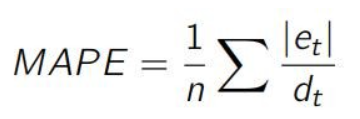

avec :

Forecast error

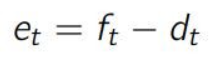

In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_true,y_pred)
print(f'Test mape: {mape : .2f}')

Test mape:  29.77


###Calculate RMSE (Root Mean Square Error)
Mesure permetant de determiner la diffence entre d'ecart notre valeur predit et valeur observer sur notre model.
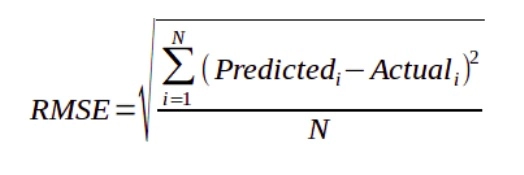

#### Using sklearn

In [ ]:
import sklearn
import math
from sklearn.metrics import mean_squared_error
mse = sklearn.metrics.mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mse)

In [ ]:
rmse

58.288832668315656

#### Using formulla

In [ ]:
rmse = sqrt(mean_squared_error(y_true, y_pred))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 58.289


### Make some prediction

In [ ]:
index = [0,len(test_y)//16, len(test_y)//10, len(test_y)//9, len(test_y)//8, len(test_y)//5, len(test_y)//4, len(test_y)//2, len(test_y)-1]
for i in index:
	print(f' true = {y_true[i]} => pred= {y_pred[i]}')
  #print(f'{date[i]} : y = {int(inv_y[i])} => yhat= {int(inv_yhat[i])}')


 true = [191. 142.] => pred= [228.85223 226.41544]
 true = [116. 230.] => pred= [229.7622  228.24525]
 true = [166. 216.] => pred= [204.76787 201.81274]
 true = [178. 158.] => pred= [220.15533 221.87021]
 true = [229. 218.] => pred= [203.55948 199.63696]
 true = [181. 111.] => pred= [208.31844 206.94286]
 true = [176. 140.] => pred= [169.1277  168.02673]
 true = [138. 200.] => pred= [259.405   260.71854]
 true = [232. 196.] => pred= [224.62247 221.14825]


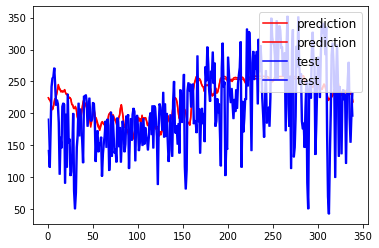

In [ ]:
# plot
pyplot.plot([x for x in range(1,inv_yhat.shape[0]+1)], inv_yhat, linestyle='-', color='red', label='prediction')
pyplot.plot([x for x in range(1,inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='test')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()